# Walk Foward Evaluation

This section mimics a real-life like approach, where a model is trained on a week worth of data, and then used to predict 7 days worth of predictions.

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS100' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=None
dtype={'SNAP_ID':int}
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA', 'IOWAIT_DELTA']# Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1
n_estimators=100

# LSTM Network Structure
epochs=50
batch=64
activation='tanh'
initializer='normal'
dropout=0.4
layer=2
state=False

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, 
                                   nrows=nrows,
                                   dtype=dtype,
                                   error_bad_lines=False,
                                   engine='python', 
                                   encoding='utf-8')
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

Skipping line 1133196: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot_table(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot_table(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape) + '\n')

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 78
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12678, 78)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (12678, 163)
Table [REP_HIST_SYSSTAT] - (12678, 1180)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'PLAN_HASH_VALUE' 'OPTIMIZER_COST'
 'OPTIMIZER_ENV_HASH_VALUE' 'SHARABLE_MEM' 'LOADED_VERSIONS'
 'VERSION_COUNT' 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE'
 'PARSING_SCHEMA_ID' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROC

### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 78: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND CHECKPOINTS PER SEC', 'BACKGROUND TIME PER SEC', 'BRANCH NODE SPLITS PER SEC', 'BRANCH NODE SPLITS PER TXN', 'CPU USAGE PER SEC', 'CPU USAGE PER TXN', 'CR BLOCKS CREATED PER SEC', 'CR BLOCKS CREATED PER TXN', 'CR UNDO RECORDS APPLIED PER SEC', 'CR UNDO RECORDS APPLIED PER TXN', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CONSISTENT READ CHANGES PER SEC', 'CONSISTENT READ CHANGES PER TXN', 'CONSISTENT READ GETS PER SEC', 'CONSISTENT READ GETS PER TXN', 'CURRENT LOGONS COUNT', 'CURRENT OS LOAD', 'CURRENT OPEN CURSORS COUNT', 'CURSOR CACHE HIT RATIO', 'DB BLOCK CHANGES PER SEC', 'DB BLOCK CHANGES PER TXN', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER SEC', 'DB BLOCK GETS PER TXN', 'DB BLOCK GETS PER U

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
print
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(12678, 1419)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA'

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(12678, 1419)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(12678, 1419)


### Redundant Feature Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(12678, 1419)

Shape before changes: [(12678, 1419)]
Shape after changes: [(12678, 526)]
Dropped a total [893]

After flatline column drop:
(12678, 526)

After additional column drop:
(12678, 516)


### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [10]:
# def get_outliers_quartile(df=None, headers=None):
#     """
#     Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
#     """
#     outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
#     for header in headers:
#         outlier_count = 0
#         try:
#             q25, q75 = np.percentile(df[header], 5), np.percentile(df[header], 95)
#             iqr = q75 - q25
#             cut_off = iqr * .6 # This values needs to remain as it. It was found to be a good value so as to capture the relavent outlier data
#             lower, upper = q25 - cut_off, q75 + cut_off
           
#             series_row = (df[df[header] > upper].index)
#             outlier_count += len(list(np.array(series_row)))
#             for id in list(np.array(series_row)):
#                 outlier_rows.append([header,id])
           
#             series_row = (df[df[header] < lower].index)
#             outlier_count += len(list(np.array(series_row)))
#             for id in list(np.array(series_row)):
#                 outlier_rows.append([header,id])
#             print(header + ' - [' + str(outlier_count) + '] outliers')
#         except Exception as e:
#             print(str(e))
   
#     unique_outlier_rows = []
#     for col, rowid in outlier_rows:
#         unique_outlier_rows.append([col,rowid])
#     return unique_outlier_rows

# #Printing outliers to screen
# outliers = get_outliers_quartile(df=df,
#                                  headers=y_label)
# print('Total Outliers: [' + str(len(outliers)) + ']\n')
# for label in y_label:
#     min_val = df[label].min()
#     max_val = df[label].max()
#     mean_val = df[label].mean()
#     std_val = df[label].std()
#     print('Label[' + label + '] - Min[' + str(min_val) + '] - Max[' + str(max_val) + '] - Mean[' + str(mean_val) + '] - Std[' + str(std_val) + ']')
# print('\n---------------------------------------------\n')
# for i in range(len(outliers)):
#     print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
    
# def edit_outliers(df=None, headers=None):
#     """
#     This method uses the interquartile method to edit all outliers to std.
#     """
#     outliers = get_outliers_quartile(df=df,
#                                      headers=y_label)
#     for label in y_label:
#         min_val = df[label].min()
#         max_val = df[label].max()
#         mean_val = df[label].mean()
#         std_val = df[label].std()
       
#         for i in range(len(outliers)):
#             if label == outliers[i][0]:
#                 df[label].iloc[outliers[i][1]] = std_val + mean_val
#                 #df[label].iloc[outliers[i][1]] = min_val
#                 # print('Header [' + str(outliers[i][0]) + '] - Location [' + str(outliers[i][1]) + '] - Value [' + str(df.iloc[outliers[i][1]][outliers[i][0]]) + ']')
#     return df

# print("DF with outliers: " + str(df.shape))
# df = edit_outliers(df=df,
#                    headers=y_label)
# print("DF with edited outliers: " + str(df.shape))

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [11]:
class Normalizer:

    @staticmethod
    def robust_scaler(dataframe):
        """
        Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
        normalization of values.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.robust_scale(dataframe.values)
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def minmax_scaler(dataframe):
        """
        Normalize df using min-max ranges for normalization method
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.minmax_scale(dataframe.values, feature_range=(0, 1))
        return pd.DataFrame(X, columns=headers)

    @staticmethod
    def normalize(dataframe):
        """
        The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
        :param dataframe: (Pandas) Pandas data matrix
        :return: (Pandas) Normalized data matrix
        """
        headers = dataframe.columns
        X = preprocessing.normalize(dataframe.values)
        return pd.DataFrame(X, columns=headers)

print('------------------BEFORE------------------')
print('------------------DF------------------')
print(df.shape)
print('\n')
#print(df.head())
#
# ROBUST SCALER
# df = Normalizer.robust_scaler(dataframe=df)
#
# MINMAX SCALER
df = Normalizer.minmax_scaler(dataframe=df)
#
# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

------------------BEFORE------------------
------------------DF------------------
(12678, 516)




------------------AFTER------------------
------------------df------------------
(12678, 516)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.000000    9.418462e-06      0.291784                  0.292452   
1  0.000079    2.014481e-09      0.488246                  0.664350   
2  0.000158    6.389749e-09      0.447345                  0.617761   
3  0.000237    5.490947e-09      0.375027                  0.437317   
4  0.000316    1.168272e-09      0.065442                  0.825621   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.048124       0.054072                  0.146687   
1       0.049796       0.103401                  0.144395   
2       0.032879       0.032475                  0.121914   
3       0.042621       0.010112                  0.132404   
4       0.031979       0.173635                  0.119854   

   EN

### Rearranging Labels

Removes the label column, and adds it at the beginning of the matrix for later usage

In [12]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (12678, 2)
Feature matrix shape: (12678, 516)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.000000    9.418462e-06      0.291784                  0.292452   
1  0.000079    2.014481e-09      0.488246                  0.664350   
2  0.000158    6.389749e-09      0.447345                  0.617761   
3  0.000237    5.490947e-09      0.375027                  0.437317   
4  0.000316    1.168272e-09      0.065442                  0.825621   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.048124       0.054072                  0.146687   
1       0.049796       0.103401                  0.144395   
2       0.032879       0.032475                  0.121914   
3       0.042621       0.010112                  0.132404   
4       0.031979       0.173635                  0.119854   

   END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  SORTS_DELTA  \
0                  0.049608     0.078155     0.256604  

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [13]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))
#
io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 9402
Number of 1s: 3276
I/O y:
[0 1]
Number of 0s: 6293
Number of 1s: 6385


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #     for header in headers:
    #         if "(t)" in header:
    #             dropped_headers.append(header)

    for i in range(1, n + 1):
        for header in headers:
            if "(t+" + str(i) + ")" in header:
                dropped_headers.append(str(header))

    return df.drop(dropped_headers, axis=1)


# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Separate labels from features
y_row = []
for i in range(lag + 1, (lag * 2) + 2):
    y_df_column_names = shifted_df.columns[len(df.columns) * i:len(df.columns) * i + len(y_label)]
    y_row.append(y_df_column_names)
    print(y_df_column_names)
    print(type(y_df_column_names))
y_df_column_names = []
for row in y_row:
    for val in row:
        y_df_column_names.append(val)

# y_df_column_names = shifted_df.columns[len(df.columns)*lag:len(df.columns)*lag + len(y_label)]
y_df = shifted_df[y_df_column_names]
X_df = shifted_df
# X_df = shifted_df.drop(columns=y_df_column_names)

# # Delete middle timesteps
X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)

Index(['var1(t+1)', 'var2(t+1)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+2)', 'var2(t+2)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+3)', 'var2(t+3)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+4)', 'var2(t+4)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+5)', 'var2(t+5)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+6)', 'var2(t+6)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+7)', 'var2(t+7)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+8)', 'var2(t+8)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+9)', 'var2(t+9)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+10)', 'var2(t+10)'], dtype='object')
<class 'pandas.core.indexes.base.Index'>
Index(['var1(t+11)', 'var2(t+11)'], dtype='object')
<class 'pandas.core.indexes.base.Ind

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [15]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var501(t-5)', 'var502(t-5)', 'var504(t-5)', 'var507(t-5)', 'var509(t-5)', 'var511(t-5)', 'var513(t-5)', 'var514(t-5)', 'var515(t-5)', 'var516(t-5)', 'var1(t-4)', 'var3(t-4)', 'var4(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)', 'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)', 'var19(t-4)', 'var20(t-4)', 'var22(t-4)', 'var23(t-4)', 'var24(t-4)', 'var34(t-4)', 'var36(t-4)', 'var39(t-4)', 'var40(t-4)', 'var41(t-4)', 'var42(t-4)', 'var47(t-4)', 'var48(t-4)', 'var49(t-4)', 'var50(t-4)', 'var51(t-4)', 'var52(t-4)', 'var53(t-4)', 'var54(t-4)', 'var55(t-4)', 'var62(t-4)', 'var63(t-4)', 'var64(t-4)', 'var66(t-4)', 'var67(t-4)', 'var69(t-4)', 'var70(t-4)', 'var71(t-4)', 'var74(t-4)', 'var76(t-4)', 'var77(t-4)', 'var78(t-4)', 'var79(t-4)', 'var80(t-4)', 'var81(t-4)', 'var85(t-4)', 'var86(t-4)', 'var90(t-4)', 'var91(t-4)', 'var92(t-4)', 'var93(t-4)', 'var102(t-4)', 'var104(t-4)', 'var105(t-4)', 'var112(t-4)', 'var113(t-4)', 'var114(t-4)', 'var115(t-4)', 'var117(t-4)', 'var118(t-4)', 'var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var123(t-4)', 'var124(t-4)', 'var125(t-4)', 'var126(t-4)', 'var127(t-4)', 'var128(t-4)', 'var129(t-4)', 'var130(t-4)', 'var131(t-4)', 'var132(t-4)', 'var133(t-4)', 'var134(t-4)', 'var135(t-4)', 'var136(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var144(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var152(t-4)', 'var153(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var161(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var169(t-4)', 'var170(t-4)', 'var171(t-4)', 'var172(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var191(t-4)', 'var192(t-4)', 'var193(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var224(t-4)', 'var225(t-4)', 'var226(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var230(t-4)', 'var231(t-4)', 'var232(t-4)', 'var233(t-4)', 'var236(t-4)', 'var237(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var244(t-4)', 'var247(t-4)', 'var248(t-4)', 'var249(t-4)', 'var250(t-4)', 'var252(t-4)', 'var254(t-4)', 'var255(t-4)', 'var256(t-4)', 'var257(t-4)', 'var258(t-4)', 'var259(t-4)', 'var260(t-4)', 'var261(t-4)', 'var264(t-4)', 'var265(t-4)', 'var266(t-4)', 'var267(t-4)', 'var268(t-4)', 'var270(t-4)', 'var271(t-4)', 'var273(t-4)', 'var274(t-4)', 'var275(t-4)', 'var276(t-4)', 'var277(t-4)', 'var278(t-4)', 'var287(t-4)', 'var289(t-4)', 'var291(t-4)', 'var292(t-4)', 'var294(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var301(t-4)', 'var302(t-4)', 'var303(t-4)', 'var304(t-4)', 'var305(t-4)', 'var306(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var316(t-4)', 'var317(t-4)', 'var318(t-4)', 'var321(t-4)', 'var322(t-4)', 'var323(t-4)', 'var324(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var335(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var341(t-4)', 'var344(t-4)', 'var348(t-4)', 'var349(t-4)', 'var355(t-4)', 'var358(t-4)', 'var359(t-4)', 'var362(t-4)', 'var363(t-4)', 'var365(t-4)', 'var366(t-4)', 'var368(t-4)', 'var369(t-4)', 'var376(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var381(t-4)', 'var382(t-4)', 'var383(t-4)', 'var384(t-4)', 'var385(t-4)', 'var386(t-4)', 'var388(t-4)', 'var389(t-4)', 'var390(t-4)', 'var393(t-4)', 'var395(t-4)', 'var397(t-4)', 'var400(t-4)', 'var401(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var407(t-4)', 'var408(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var414(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var419(t-4)', 'var420(t-4)', 'var421(t-4)', 'var422(t-4)', 'var423(t-4)', 'var424(t-4)', 'var425(t-4)', 'var426(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var454(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var467(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var478(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var489(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var510(t-4)', 'var511(t-4)', 'var513(t-4)', 'var514(t-4)', 'var1(t-3)', 'var2(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var10(t-3)', 'var11(t-3)', 'var14(t-3)', 'var15(t-3)', 'var17(t-3)', 'var18(t-3)', 'var25(t-3)', 'var26(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)', 'var31(t-3)', 'var32(t-3)', 'var33(t-3)', 'var34(t-3)', 'var35(t-3)', 'var41(t-3)', 'var42(t-3)', 'var44(t-3)', 'var47(t-3)', 'var50(t-3)', 'var51(t-3)', 'var53(t-3)', 'var57(t-3)', 'var62(t-3)', 'var67(t-3)', 'var68(t-3)', 'var71(t-3)', 'var77(t-3)', 'var78(t-3)', 'var79(t-3)', 'var80(t-3)', 'var81(t-3)', 'var82(t-3)', 'var83(t-3)', 'var84(t-3)', 'var85(t-3)', 'var86(t-3)', 'var89(t-3)', 'var96(t-3)', 'var97(t-3)', 'var98(t-3)', 'var101(t-3)', 'var109(t-3)', 'var110(t-3)', 'var113(t-3)', 'var115(t-3)', 'var116(t-3)', 'var117(t-3)', 'var118(t-3)', 'var125(t-3)', 'var126(t-3)', 'var127(t-3)', 'var130(t-3)', 'var131(t-3)', 'var133(t-3)', 'var134(t-3)', 'var137(t-3)', 'var139(t-3)', 'var140(t-3)', 'var142(t-3)', 'var143(t-3)', 'var144(t-3)', 'var145(t-3)', 'var146(t-3)', 'var147(t-3)', 'var149(t-3)', 'var156(t-3)', 'var157(t-3)', 'var158(t-3)', 'var159(t-3)', 'var160(t-3)', 'var161(t-3)', 'var167(t-3)', 'var168(t-3)', 'var169(t-3)', 'var170(t-3)', 'var171(t-3)', 'var172(t-3)', 'var173(t-3)', 'var175(t-3)', 'var177(t-3)', 'var179(t-3)', 'var181(t-3)', 'var182(t-3)', 'var184(t-3)', 'var187(t-3)', 'var192(t-3)', 'var194(t-3)', 'var196(t-3)', 'var197(t-3)', 'var198(t-3)', 'var199(t-3)', 'var200(t-3)', 'var202(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var212(t-3)', 'var214(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var239(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var255(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var260(t-3)', 'var261(t-3)', 'var262(t-3)', 'var263(t-3)', 'var264(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var275(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var282(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var292(t-3)', 'var293(t-3)', 'var294(t-3)', 'var300(t-3)', 'var301(t-3)', 'var306(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var312(t-3)', 'var313(t-3)', 'var315(t-3)', 'var317(t-3)', 'var318(t-3)', 'var319(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var326(t-3)', 'var335(t-3)', 'var336(t-3)', 'var337(t-3)', 'var338(t-3)', 'var339(t-3)', 'var340(t-3)', 'var342(t-3)', 'var343(t-3)', 'var346(t-3)', 'var347(t-3)', 'var349(t-3)', 'var352(t-3)', 'var353(t-3)', 'var355(t-3)', 'var357(t-3)', 'var359(t-3)', 'var364(t-3)', 'var365(t-3)', 'var366(t-3)', 'var367(t-3)', 'var374(t-3)', 'var376(t-3)', 'var377(t-3)', 'var378(t-3)', 'var379(t-3)', 'var382(t-3)', 'var383(t-3)', 'var384(t-3)', 'var385(t-3)', 'var386(t-3)', 'var387(t-3)', 'var389(t-3)', 'var391(t-3)', 'var397(t-3)', 'var398(t-3)', 'var399(t-3)', 'var401(t-3)', 'var402(t-3)', 'var418(t-3)', 'var419(t-3)', 'var421(t-3)', 'var423(t-3)', 'var424(t-3)', 'var425(t-3)', 'var427(t-3)', 'var428(t-3)', 'var429(t-3)', 'var430(t-3)', 'var432(t-3)', 'var436(t-3)', 'var437(t-3)', 'var438(t-3)', 'var439(t-3)', 'var441(t-3)', 'var444(t-3)', 'var445(t-3)', 'var446(t-3)', 'var447(t-3)', 'var450(t-3)', 'var451(t-3)', 'var452(t-3)', 'var454(t-3)', 'var455(t-3)', 'var456(t-3)', 'var457(t-3)', 'var458(t-3)', 'var462(t-3)', 'var463(t-3)', 'var464(t-3)', 'var469(t-3)', 'var471(t-3)', 'var472(t-3)', 'var474(t-3)', 'var475(t-3)', 'var476(t-3)', 'var478(t-3)', 'var481(t-3)', 'var484(t-3)', 'var485(t-3)', 'var489(t-3)', 'var490(t-3)', 'var491(t-3)', 'var492(t-3)', 'var494(t-3)', 'var496(t-3)', 'var497(t-3)', 'var498(t-3)', 'var499(t-3)', 'var500(t-3)', 'var501(t-3)', 'var502(t-3)', 'var503(t-3)', 'var504(t-3)', 'var505(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var512(t-3)', 'var513(t-3)', 'var514(t-3)', 'var515(t-3)', 'var516(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var26(t-2)', 'var27(t-2)', 'var29(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var42(t-2)', 'var44(t-2)', 'var45(t-2)', 'var46(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var51(t-2)', 'var53(t-2)', 'var54(t-2)', 'var74(t-2)', 'var75(t-2)', 'var77(t-2)', 'var79(t-2)', 'var80(t-2)', 'var81(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var86(t-2)', 'var99(t-2)', 'var100(t-2)', 'var101(t-2)', 'var102(t-2)', 'var105(t-2)', 'var155(t-2)', 'var158(t-2)', 'var159(t-2)', 'var168(t-2)', 'var169(t-2)', 'var171(t-2)', 'var172(t-2)', 'var173(t-2)', 'var184(t-2)', 'var186(t-2)', 'var187(t-2)', 'var188(t-2)', 'var190(t-2)', 'var191(t-2)', 'var194(t-2)', 'var195(t-2)', 'var196(t-2)', 'var198(t-2)', 'var199(t-2)', 'var201(t-2)', 'var202(t-2)', 'var207(t-2)', 'var213(t-2)', 'var214(t-2)', 'var216(t-2)', 'var217(t-2)', 'var228(t-2)', 'var231(t-2)', 'var237(t-2)', 'var238(t-2)', 'var239(t-2)', 'var241(t-2)', 'var243(t-2)', 'var254(t-2)', 'var255(t-2)', 'var256(t-2)', 'var259(t-2)', 'var260(t-2)', 'var261(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var268(t-2)', 'var269(t-2)', 'var270(t-2)', 'var272(t-2)', 'var273(t-2)', 'var274(t-2)', 'var275(t-2)', 'var276(t-2)', 'var277(t-2)', 'var278(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var292(t-2)', 'var293(t-2)', 'var295(t-2)', 'var296(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var300(t-2)', 'var301(t-2)', 'var302(t-2)', 'var303(t-2)', 'var304(t-2)', 'var305(t-2)', 'var306(t-2)', 'var307(t-2)', 'var308(t-2)', 'var309(t-2)', 'var310(t-2)', 'var311(t-2)', 'var312(t-2)', 'var313(t-2)', 'var314(t-2)', 'var315(t-2)', 'var316(t-2)', 'var317(t-2)', 'var318(t-2)', 'var319(t-2)', 'var320(t-2)', 'var321(t-2)', 'var322(t-2)', 'var323(t-2)', 'var324(t-2)', 'var325(t-2)', 'var326(t-2)', 'var327(t-2)', 'var328(t-2)', 'var329(t-2)', 'var330(t-2)', 'var331(t-2)', 'var333(t-2)', 'var334(t-2)', 'var335(t-2)', 'var336(t-2)', 'var337(t-2)', 'var350(t-2)', 'var364(t-2)', 'var367(t-2)', 'var368(t-2)', 'var369(t-2)', 'var376(t-2)', 'var377(t-2)', 'var378(t-2)', 'var379(t-2)', 'var380(t-2)', 'var382(t-2)', 'var387(t-2)', 'var389(t-2)', 'var390(t-2)', 'var391(t-2)', 'var392(t-2)', 'var393(t-2)', 'var396(t-2)', 'var397(t-2)', 'var415(t-2)', 'var423(t-2)', 'var440(t-2)', 'var441(t-2)', 'var442(t-2)', 'var445(t-2)', 'var466(t-2)', 'var476(t-2)', 'var480(t-2)', 'var481(t-2)', 'var482(t-2)', 'var487(t-2)', 'var488(t-2)', 'var489(t-2)', 'var497(t-2)', 'var498(t-2)', 'var499(t-2)', 'var500(t-2)', 'var502(t-2)', 'var503(t-2)', 'var505(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var512(t-2)', 'var513(t-2)', 'var514(t-2)', 'var515(t-2)', 'var516(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var152(t)', 'var153(t)', 'var154(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var242(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var319(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var332(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)']
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var501(t-5)  var502(t-5)  var504(t-5)  var507(t-5)  var509(t-5)  \
12     0.001632     0.982408          0.0     0.001828          0.0   
13     0.001705     0.982408          0.0     0.001924          0.0   
14     0.001787     0.982408          0.0     0.002045          0.0   
15     0.001873     0.982408          0.0     0.002147          0.0   
16     0.001949     0.982408          0.0     0.002268          0.0   

    var511(t-5)  var513(t-5)  var514(t-5)  var515(t-5)  var516(t-5)  \
12          0.0     0.001663          0.0          0.0     0.999874   
13          0.0     0.001732          0.0          0.0     0.999874   
14          0.0     0.001853          0.0          0.0     0.999874   
15          0.0     0.001936          0.0          0.0     0.999874   
16          0.0     0.002039          0.0          0.0     0.999874   

      ...      var376(t)  var377(t)  var378(t)  var379(t)  var380(t)  \
12    ...       0.991243   0.000066   0.011825   0.000764        0.0   
13

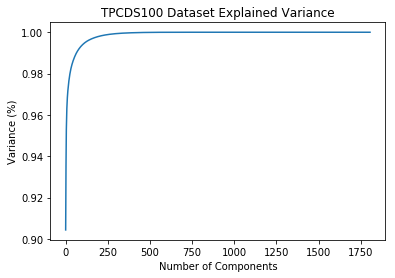

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    17.769557     2.537554     3.311838     0.720476    -0.913218   
1    17.744244     2.523872     2.298145     0.508384    -0.883008   
2    17.719616     2.507806     1.271495     0.155263    -0.703628   
3    17.707141     2.494075     0.649591     0.006601    -0.785083   
4    17.693968     2.473816    -0.082042    -0.231971    -0.675978   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0    -0.018777     0.009677     0.222064    -0.052466    -0.049391   
1    -0.046195     0.511080     0.229226    -0.279076     0.400811   
2    -0.070033     0.744302     0.236862    -0.467083     0.446553   
3    -0.094778     0.815863     0.256046    -0.504122     0.405971   
4    -0.083014     0.818826     0.247673    -0.523264     0.156402   

       ...       Component_54  Component_55  Component_56  Component_57  \
0      ...           0.299548     -0.397354      0.1

In [16]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## LSTM Classification (Many to Many)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- The LSTM recurrent layer comprised of memory units is called LSTM().
- A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().
- The first layer in the network must define the number of inputs to expect.
- Input must be three-dimensional, comprised of samples, timesteps, and features.
    - **Samples:** These are the rows in your data.
    - **Timesteps:** These are the past observations for a feature, such as lag variables.
    - **Features:** These are columns in your data.
- Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [17]:
# LSTM Class
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', lstm_layers=1, dropout=.0,
                 stateful=False, y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param lstm_layers   - (Integer) Denotes the number of LSTM layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param stateful      - (Boolean) Denotes whether state is used as initial state for next training batch.
        :param: y_labels     - (List) List of target label names
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')
        
        # self.__model.add(ke.layers.Embedding(2+1, 32, input_length=X.shape[1]))
        for i in range(0, lstm_layers - 1):  # If lstm_layers == 1, this for loop logic is skipped.
            if stateful:
                if i == 0:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    batch_input_shape=(X.shape[0],
                                                                       X.shape[1],
                                                                       X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
                else:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    input_shape=(X.shape[1],
                                                                 X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                return_sequences=True,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                stateful=stateful))
            self.__model.add(ke.layers.Dropout(dropout))
        if lstm_layers > 1:
            self.__model.add(ke.layers.LSTM(X.shape[2],
                                            input_shape=(X.shape[1],
                                                         X.shape[2]),
                                            stateful=stateful,
                                            recurrent_dropout=dropout,
                                            recurrent_initializer=initializer,
                                            activation=activation,
                                            return_sequences=False))
        else:
            if stateful:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                batch_input_shape=(X.shape[0],
                                                                   X.shape[1],
                                                                   X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
        self.__model.add(ke.layers.Dropout(dropout))
        # self.__model.add(ke.layers.TimeDistributed(ke.layers.Dense(self.__lag * len(self.__y_labels), kernel_initializer=initializer)))
        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: batch_size - (Integer) Integer value denoting LSTM training batch_size
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during LSTM training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              stateful, rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained LSTM models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: batch      - (Integer) Integer denoting LSTM batch size.
        :param: epoch      - (Integer) Integer denoting number of LSTM training iterations.
        :param: layer      - (Integer) Integer denoting number of LSTM layers
        :param: activation - (String) String denoting activation for LSTM layers.
        :param: initializer- (String) String denoting LSTM initializing weights.
        :param: stateful   - (Bool) Boolean flag which denotes whether LSTM model is trained in stateful mode or not.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by LSTM training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'stateful', 'dropout', 'activation',
                       'initializer', 'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'stateful': stateful,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows, :]

### Time Step (1) - Training (CPU)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(6327, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(6327, 12)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_amd_tonga.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 66,828
Trainable params: 66,828
Non-trainable params: 0
_________________________________________________________________
None
Train on 6327 samples, validate on 6327 samples
Epoch 1/50
 - 9s - loss: 0.0330 - mean_squared_error: 0.0330 - mean_absolute_error: 0

Epoch 39/50
 - 2s - loss: 4.7619e-04 - mean_squared_error: 4.7619e-04 - mean_absolute_error: 0.0167 - val_loss: 5.1277e-05 - val_mean_squared_error: 5.1277e-05 - val_mean_absolute_error: 0.0055
Epoch 40/50
 - 2s - loss: 4.6533e-04 - mean_squared_error: 4.6533e-04 - mean_absolute_error: 0.0165 - val_loss: 4.0424e-05 - val_mean_squared_error: 4.0424e-05 - val_mean_absolute_error: 0.0050
Epoch 41/50
 - 2s - loss: 4.6007e-04 - mean_squared_error: 4.6007e-04 - mean_absolute_error: 0.0164 - val_loss: 4.6929e-05 - val_mean_squared_error: 4.6929e-05 - val_mean_absolute_error: 0.0053
Epoch 42/50
 - 2s - loss: 4.6976e-04 - mean_squared_error: 4.6976e-04 - mean_absolute_error: 0.0166 - val_loss: 4.1373e-05 - val_mean_squared_error: 4.1373e-05 - val_mean_absolute_error: 0.0049
Epoch 43/50
 - 2s - loss: 4.6162e-04 - mean_squared_error: 4.6162e-04 - mean_absolute_error: 0.0164 - val_loss: 4.2672e-05 - val_mean_squared_error: 4.2672e-05 - val_mean_absolute_error: 0.0050
Epoch 44/50
 - 2s - loss: 4.52

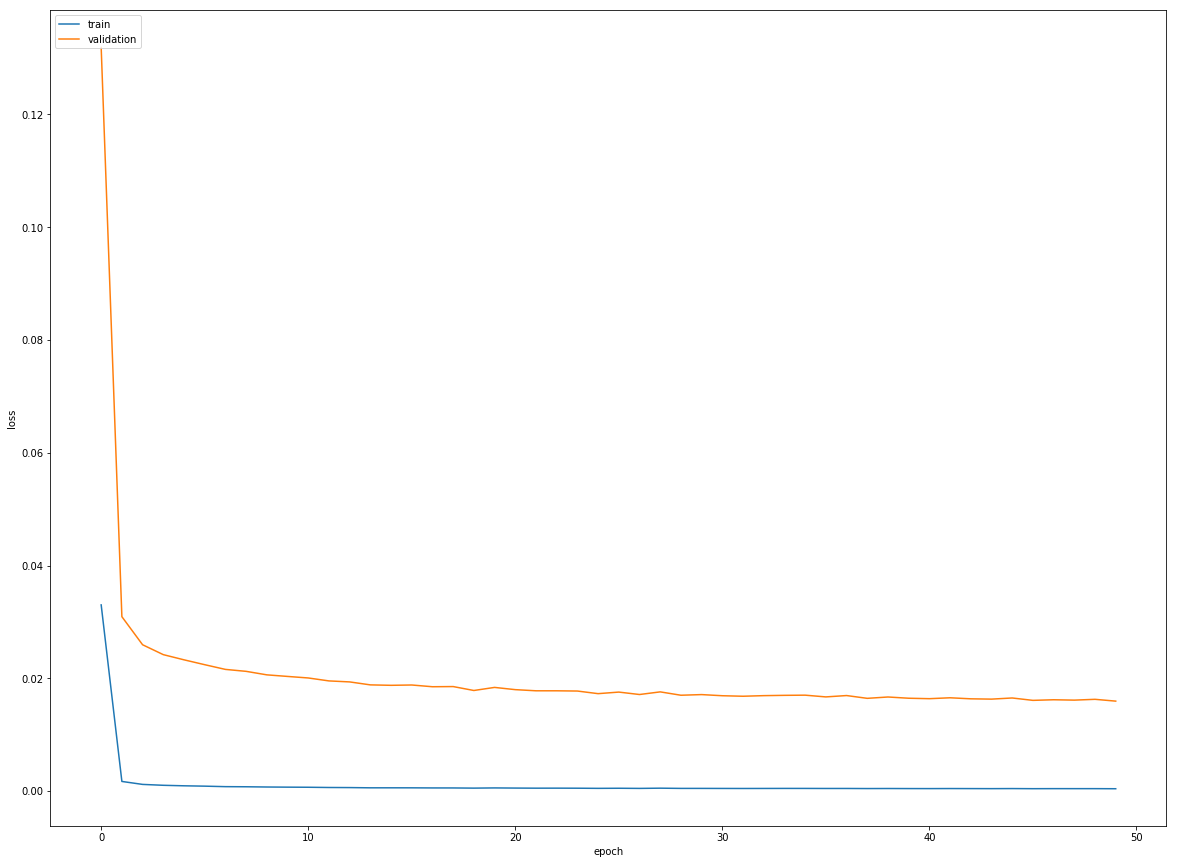

Wall time: 2min 1s


In [18]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [19]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(len(y_labels2)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (903, 1, 64)
Label vectors: (903, 12)
Label: 0
Accuracy: 0.9922480620155039
F1Score: 0.9960113960113961
--------------------------
Label: 1
Accuracy: 0.9900332225913622
F1Score: 0.9946396664681357
--------------------------
Label: 2
Accuracy: 0.9922480620155039
F1Score: 0.9960113960113961
--------------------------
Label: 3
Accuracy: 0.9889258028792912
F1Score: 0.994047619047619
--------------------------
Label: 4
Accuracy: 0.9922480620155039
F1Score: 0.9960113960113961
--------------------------
Label: 5
Accuracy: 0.9889258028792912
F1Score: 0.994047619047619
--------------------------
Label: 6
Accuracy: 0.9922480620155039
F1Score: 0.9960113960113961
--------------------------
Label: 7
Accuracy: 0.9889258028792912
F1Score: 0.994047619047619
--------------------------
Label: 8
Accuracy: 0.9922480620155039
F1Score: 0.9960113960113961
--------------------------
Label: 9
Accuracy: 0.9889258028792912
F1Score: 0.994047619047619
--------------------------
Label: 10
Acc

### Scoring per day  (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

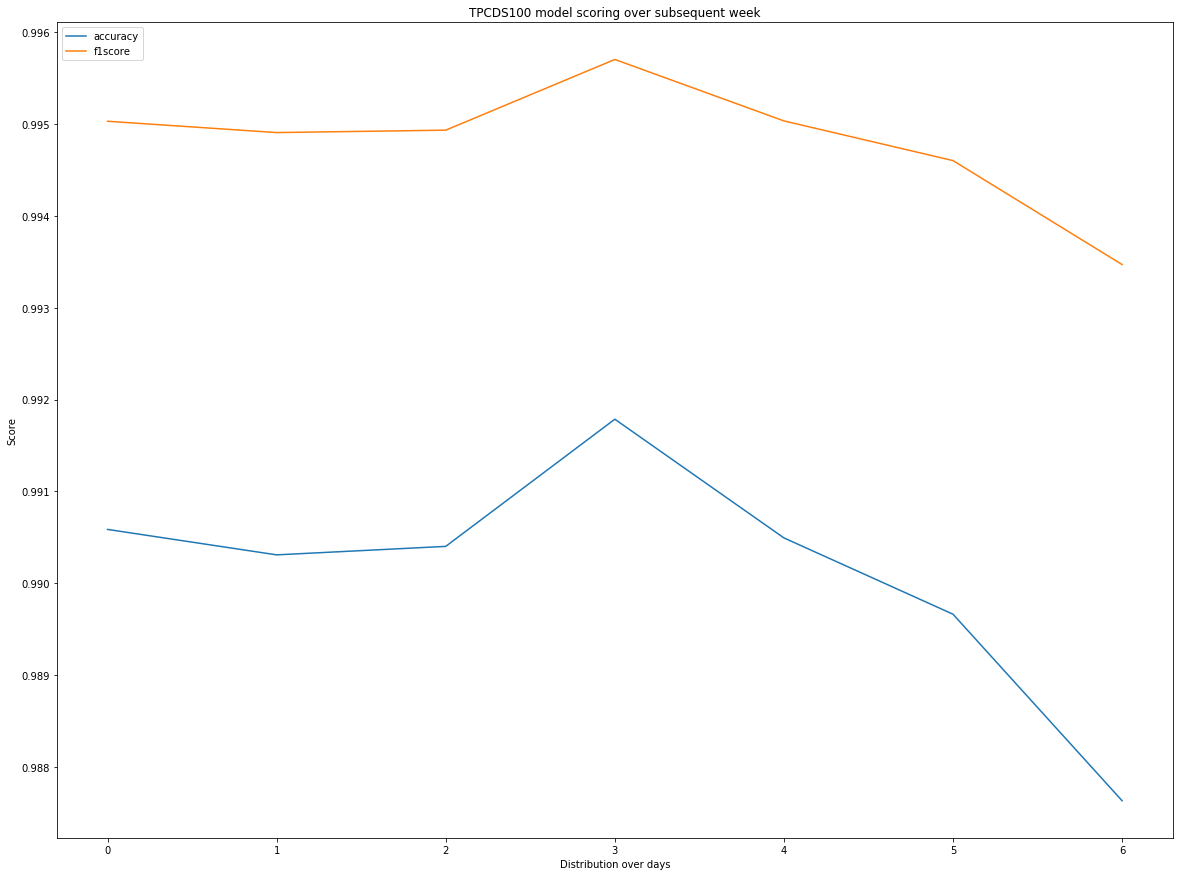

In [20]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(6327, 12)] Type - <class 'numpy.ndarray'>
X_validate shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(6327, 12)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Tot

Epoch 37/50
 - 2s - loss: 1.0510e-04 - mean_squared_error: 1.0510e-04 - mean_absolute_error: 0.0012 - val_loss: 1.8235e-04 - val_mean_squared_error: 1.8235e-04 - val_mean_absolute_error: 9.5438e-04
Epoch 38/50
 - 2s - loss: 1.0511e-04 - mean_squared_error: 1.0511e-04 - mean_absolute_error: 0.0012 - val_loss: 1.8234e-04 - val_mean_squared_error: 1.8234e-04 - val_mean_absolute_error: 9.3958e-04
Epoch 39/50
 - 2s - loss: 1.0516e-04 - mean_squared_error: 1.0516e-04 - mean_absolute_error: 0.0011 - val_loss: 1.8233e-04 - val_mean_squared_error: 1.8233e-04 - val_mean_absolute_error: 9.2692e-04
Epoch 40/50
 - 2s - loss: 1.0469e-04 - mean_squared_error: 1.0469e-04 - mean_absolute_error: 0.0011 - val_loss: 1.8233e-04 - val_mean_squared_error: 1.8233e-04 - val_mean_absolute_error: 9.1430e-04
Epoch 41/50
 - 2s - loss: 1.0506e-04 - mean_squared_error: 1.0506e-04 - mean_absolute_error: 0.0011 - val_loss: 1.8232e-04 - val_mean_squared_error: 1.8232e-04 - val_mean_absolute_error: 9.0114e-04
Epoch 42/5

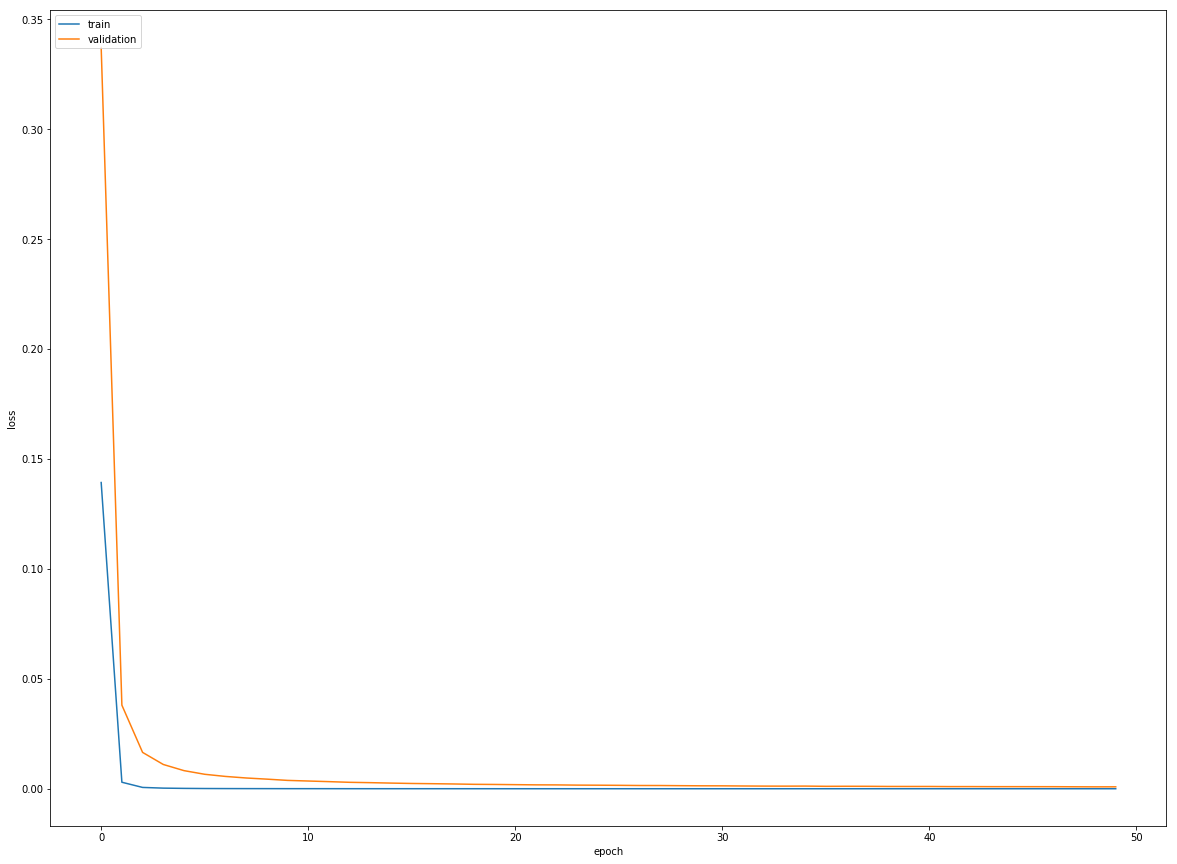

Wall time: 1min 53s


In [21]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [22]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(len(y_labels2)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (903, 1, 64)
Label vectors: (903, 12)
Label: 0
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
A

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.9976467331118493
F1Score: 0.0
--------------------------
----------------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.9971699274024854
F1Score: 0.0
----

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9922480620155039
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.9970238095238094
F1Score: 0.0
-------------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.997471391657438
F1Score: 0.0
--------------------------
----------------------------------------
Day 6
Feature vectors: (903, 1, 64)
Label 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9977851605758582
F1Score: 0.5
--------------------------
Label: 1
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.997539067306509
F1Score: 0.0069444

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Label: 0
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 1
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 11
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Averaged Day 12 Accuracy: 0.9975083056478403
F1Score: 0.005952380952380952
--------------------------
-----

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

### Scoring per day  (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

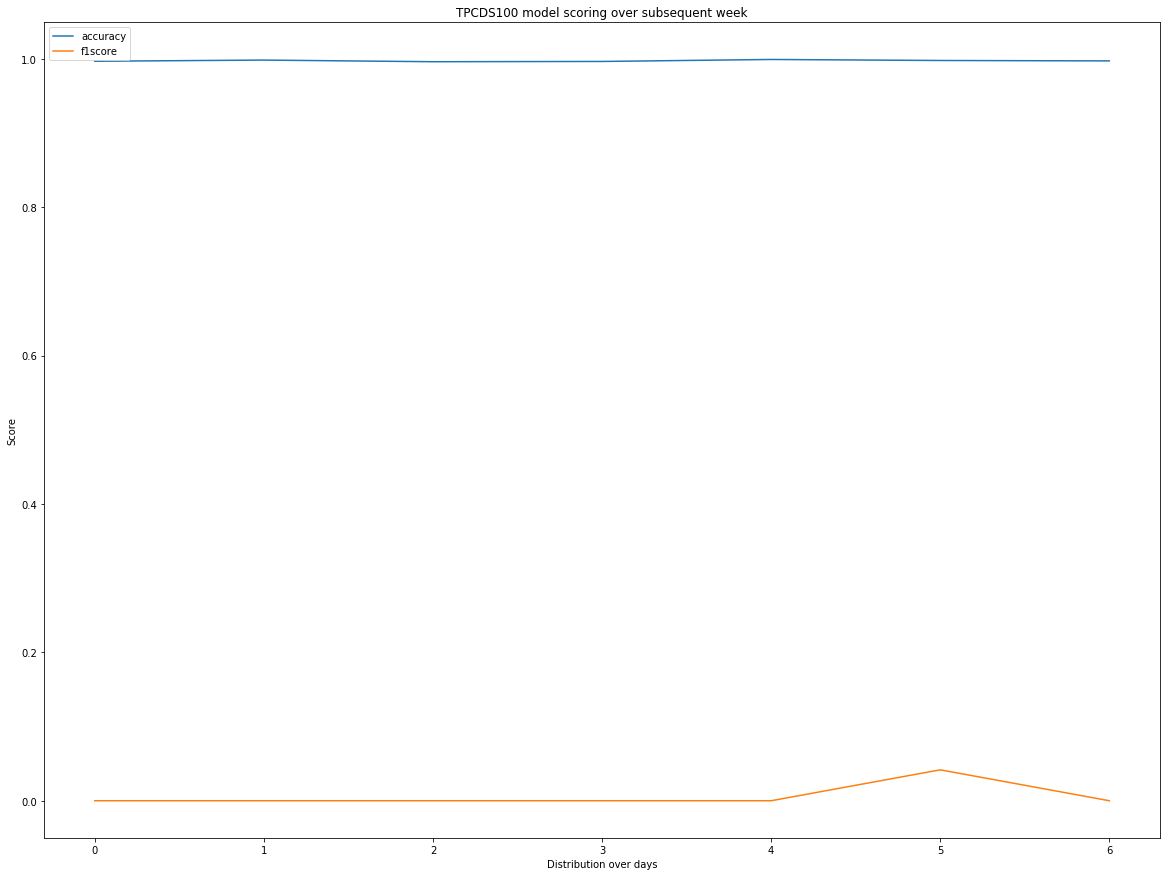

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(6327, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(6327, 1, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(6327, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1560      
Tot

Epoch 38/50
 - 2s - loss: 5.8955e-04 - mean_squared_error: 5.8955e-04 - mean_absolute_error: 0.0145 - val_loss: 1.1187e-04 - val_mean_squared_error: 1.1187e-04 - val_mean_absolute_error: 0.0052
Epoch 39/50
 - 2s - loss: 5.7324e-04 - mean_squared_error: 5.7324e-04 - mean_absolute_error: 0.0142 - val_loss: 1.0239e-04 - val_mean_squared_error: 1.0239e-04 - val_mean_absolute_error: 0.0045
Epoch 40/50
 - 2s - loss: 5.7013e-04 - mean_squared_error: 5.7013e-04 - mean_absolute_error: 0.0141 - val_loss: 1.0562e-04 - val_mean_squared_error: 1.0562e-04 - val_mean_absolute_error: 0.0047
Epoch 41/50
 - 2s - loss: 5.4559e-04 - mean_squared_error: 5.4559e-04 - mean_absolute_error: 0.0137 - val_loss: 9.6836e-05 - val_mean_squared_error: 9.6836e-05 - val_mean_absolute_error: 0.0043
Epoch 42/50
 - 2s - loss: 5.5025e-04 - mean_squared_error: 5.5025e-04 - mean_absolute_error: 0.0137 - val_loss: 1.1674e-04 - val_mean_squared_error: 1.1674e-04 - val_mean_absolute_error: 0.0054
Epoch 43/50
 - 2s - loss: 5.50

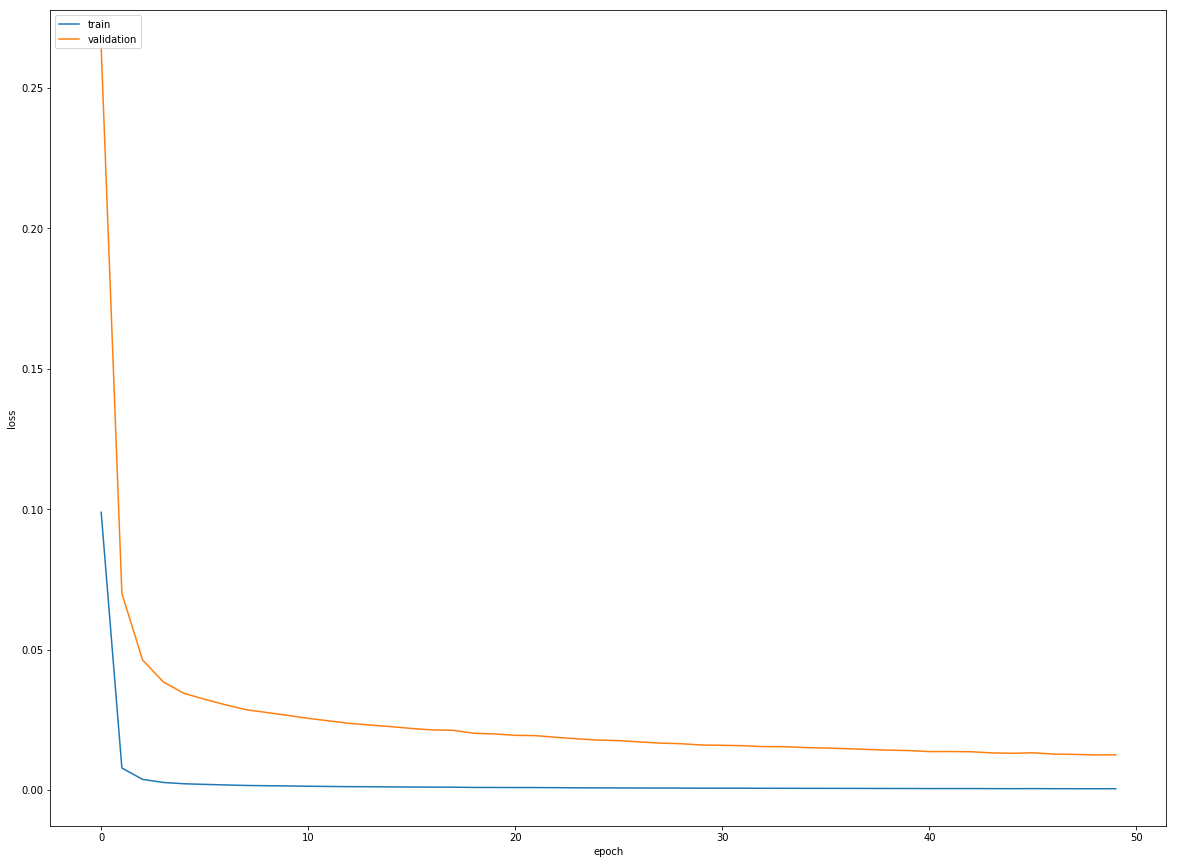

Wall time: 1min 56s


In [24]:
%%time
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [25]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(lag * len(y_label)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (903, 1, 64)
Label vectors: (903, 24)
Label: 0
Accuracy: 0.9856035437430787
F1Score: 0.9926262053318208
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9867109634551495
F1Score: 0.9931972789115645
--------------------------
Label: 3
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9867109634551495
F1Score: 0.9931972789115645
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9867109634551495
F1Score: 0.9931972789115645
--------------------------
Label: 7
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9867109634551495
F1Score: 0.9931972789115645
--------------------------
Label: 9
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9867109634551495
F1Score: 0.9931972789115645
-----------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9811738648947951
F1Score: 0.9903900508762014
--------------------------
Label: 1
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9811738648947951
F1Score: 0.9903900508762014
--------------------------
Label: 3
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9800664451827242
F1Score: 0.9898305084745762
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9800664451827242
F1Score: 0.9898305084745762
--------------------------
Label: 7
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9789590254706534
F1Score: 0.9892715979672501
--------------------------
Label: 9
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9789590254706534
F1Score: 0.9892715979672501
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 1
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 3
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9856035437430787
F1Score: 0.9925841414717625
--------------------------
Label: 11
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 12
Accurac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 5
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 7
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 9
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9778516057585825
F1Score: 0.9886749716874292
--------------------------
Label: 11
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
La

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9856035437430787
F1Score: 0.9926094371802161
--------------------------
Label: 1
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9856035437430787
F1Score: 0.9926094371802161
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9856035437430787
F1Score: 0.9926094371802161
--------------------------
Label: 5
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9844961240310077
F1Score: 0.9920454545454546
--------------------------
Label: 7
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9844961240310077
F1Score: 0.9920454545454546
--------------------------
Label: 9
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9844961240310077
F1Score: 0.9920454545454546
--------------------------
Label: 11
Accuracy: 0.9944629014396457
F1Score: 0.0
--------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9811738648947951
F1Score: 0.9903133903133903
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9811738648947951
F1Score: 0.9903133903133903
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9811738648947951
F1Score: 0.9903133903133903
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9811738648947951
F1Score: 0.9903133903133903
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9811738648947951
F1Score: 0.9903133903133903
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9800664451827242
F1Score: 0.989749430523918
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9800664451827242
F1Score: 0.9897494305239

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 3
Accuracy: 0.9955703211517165
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 7
Accuracy: 0.9977851605758582
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 9
Accuracy: 0.9988925802879292
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9745293466223699
F1Score: 0.9867128827267475
--------------------------
Label: 11
Accuracy: 0.9988925802879292
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

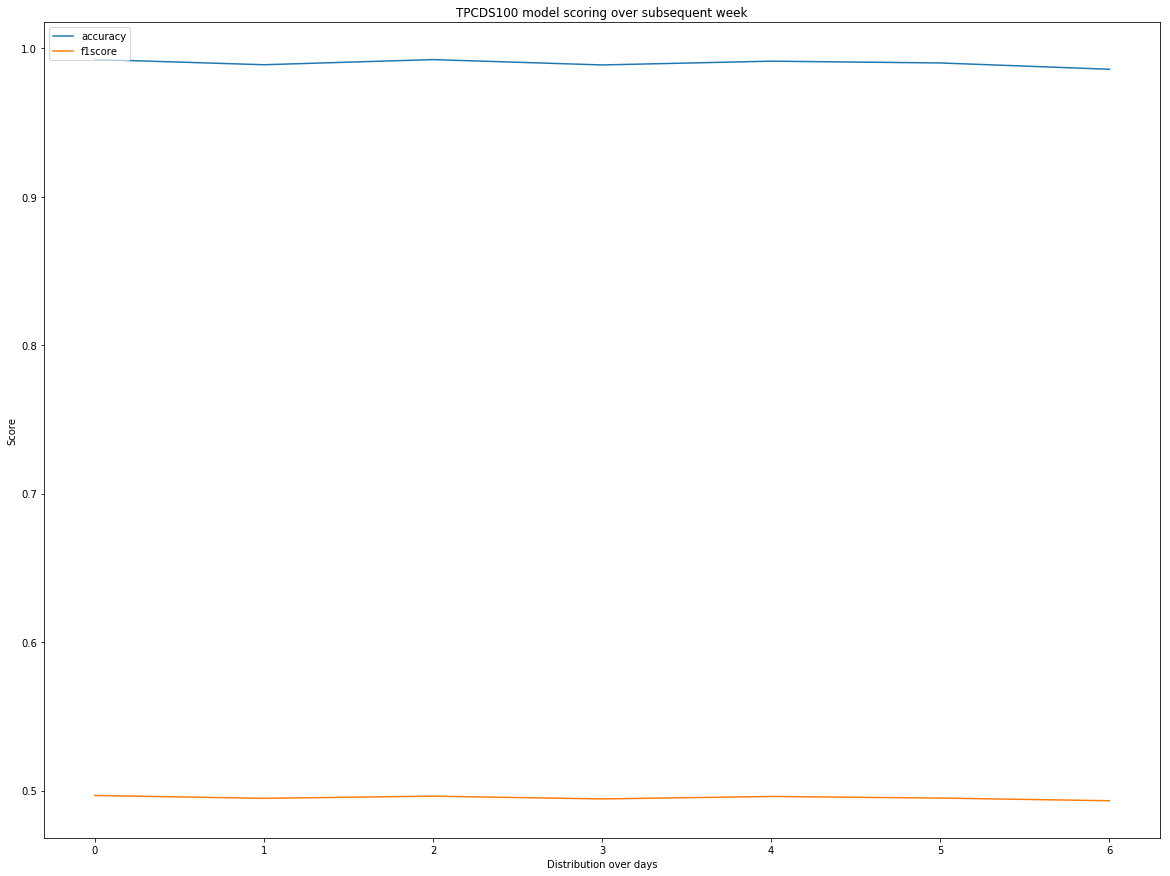

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (2) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(3163, 2, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(3163, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(3163, 2, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(3163, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 2, 64)             33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1560      
Tot

Epoch 40/50
 - 1s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1217 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1289
Epoch 41/50
 - 1s - loss: 0.0385 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1218 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1292
Epoch 42/50
 - 1s - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1213 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1293
Epoch 43/50
 - 1s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1197 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1297
Epoch 44/50
 - 1s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1194 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1303
Epoch 45/50
 - 1s - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1195 - val_loss: 0.0448

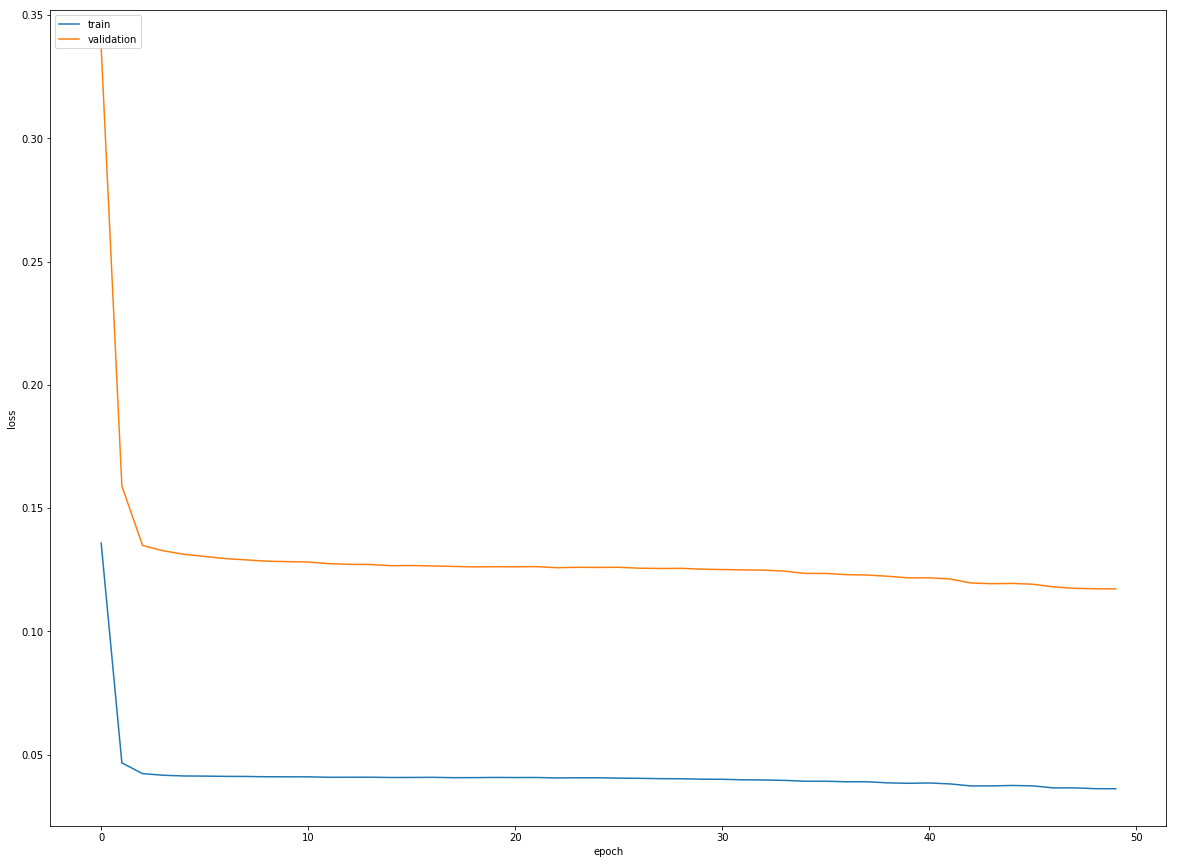

Wall time: 1min 9s


In [27]:
%%time
timestep = 2
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (2) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [28]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(lag * len(y_label)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (451, 2, 64)
Label vectors: (451, 24)
Label: 0
Accuracy: 0.9866962305986696
F1Score: 0.9933035714285714
--------------------------
Label: 1
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9866962305986696
F1Score: 0.9933035714285714
--------------------------
Label: 3
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9866962305986696
F1Score: 0.9933035714285714
--------------------------
Label: 5
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9889135254988913
F1Score: 0.9944258639910815
--------------------------
Label: 7
Accuracy: 0.9955654101995566
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9889135254988913
F1Score: 0.9944258639910815
--------------------------
Label: 9
Accuracy: 0.9955654101995566
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9889135254988913
F1Score: 0.9944258639910815
-----------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Label: 0
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 1
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 3
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 5
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 7
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 9
Accuracy: 0.9955654101995566
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 11
Accuracy: 0.9977827050997783
F1Score: 0.0
-----

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 1
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 3
Accuracy: 0.9955654101995566
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 5
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9667405764966741
F1Score: 0.9830890642615558
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accurac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 1
Accuracy: 0.9955654101995566
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 5
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 7
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 9
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9844789356984479
F1Score: 0.9921787709497207
--------------------------
Label: 11
Accuracy: 0.9977827050997783
F1Score: 0.0
--------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.975609756097561
F1Score: 0.9876543209876543
--

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

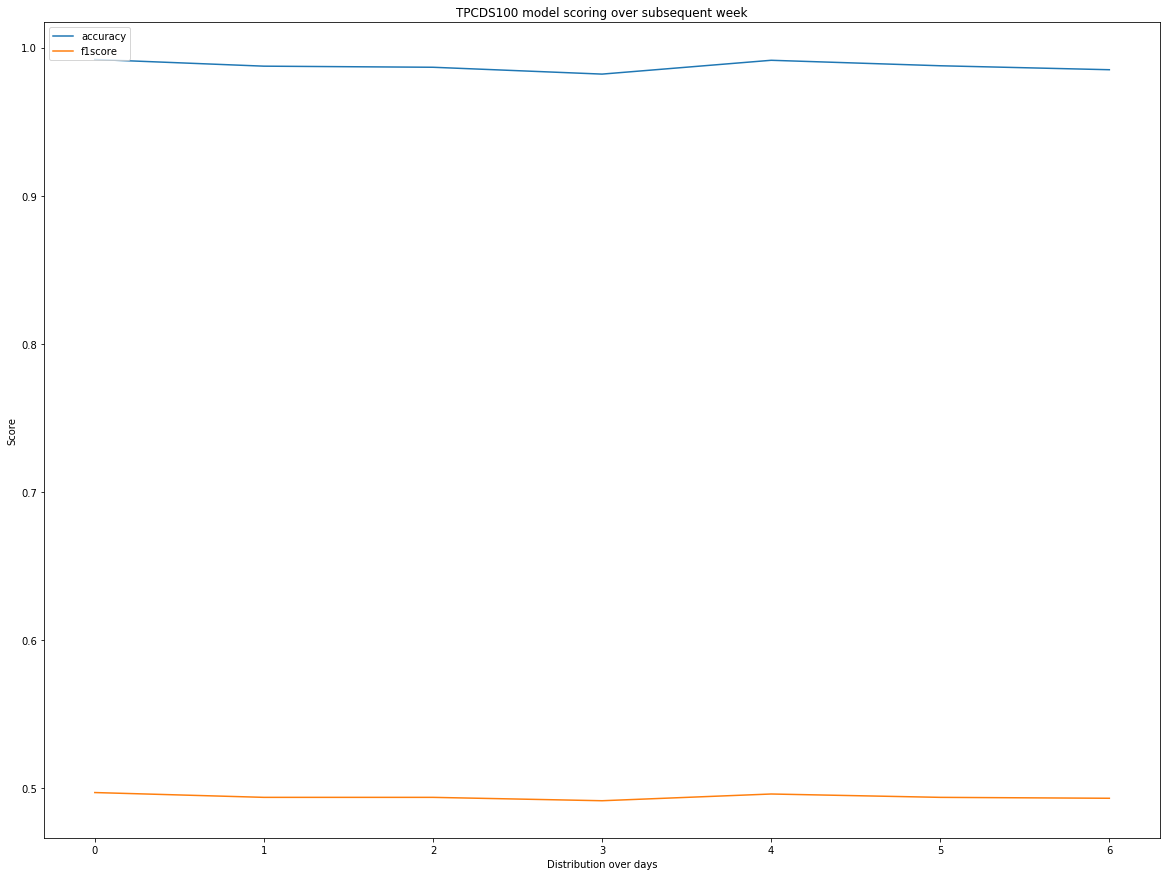

In [29]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (3) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(2109, 3, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(2109, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(2109, 3, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(2109, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                1560      
Tot

Epoch 40/50
 - 1s - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1257 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1297
Epoch 41/50
 - 1s - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1251 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1301
Epoch 42/50
 - 1s - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1238 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1304
Epoch 43/50
 - 1s - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1223 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1311
Epoch 44/50
 - 1s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1213 - val_loss: 0.0458 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1316
Epoch 45/50
 - 1s - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1200 - val_loss: 0.0459

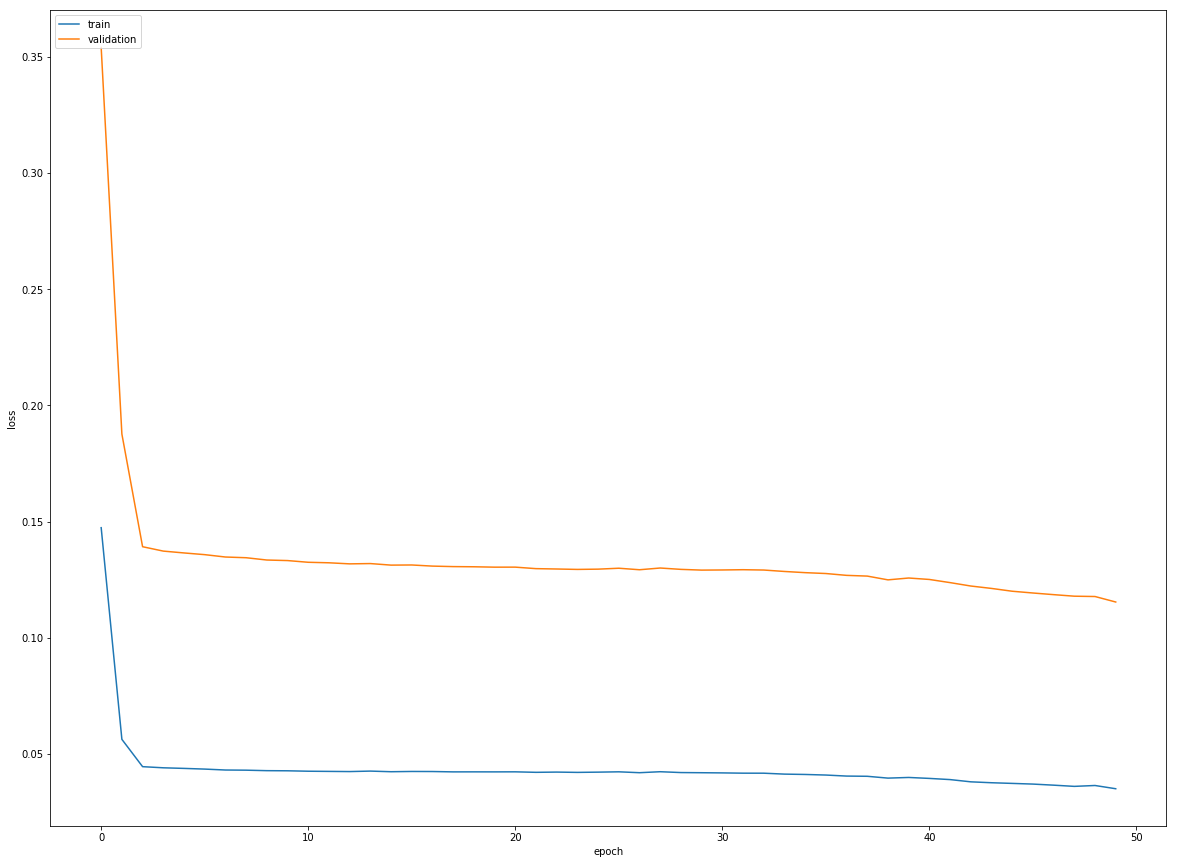

Wall time: 53.5 s


In [30]:
%%time
timestep = 3
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (3) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [31]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(lag * len(y_label)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (301, 3, 64)
Label vectors: (301, 24)
Label: 0
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 1
Accuracy: 0.9700996677740864
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 3
Accuracy: 0.9700996677740864
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 5
Accuracy: 0.973421926910299
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 7
Accuracy: 0.973421926910299
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 9
Accuracy: 0.973421926910299
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set 

Label: 0
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9634551495016611
F1Score: 0.9813874788494078
--------------------------
Label: 11
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9634551495

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9800664451827242
F1Score: 0.9899328859060402
--------------------------
Label: 11
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.9800664451827242
F1Score:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 1
Accuracy: 0.9933554817275747
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 3
Accuracy: 0.9900332225913622
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 5
Accuracy: 0.9933554817275747
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 7
Accuracy: 0.9933554817275747
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 9
Accuracy: 0.9933554817275747
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9767441860465116
F1Score: 0.988235294117647
--------------------------
Label: 11
Accuracy: 0.9933554817275747
F1Score: 0.0
-----

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set 

Label: 0
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 3
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9833887043189369
F1Score: 0.9916247906197655
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accurac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 3
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 7
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 9
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9667774086378738
F1Score: 0.9831081081081081
--------------------------
Label: 11
Accuracy: 0.9966777408637874
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set 

Label: 0
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 1
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 3
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 5
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 7
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 9
Accuracy: 0.9966777408637874
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9700996677740864
F1Score: 0.9848229342327149
--------------------------
Label: 11
Accuracy: 0.9966777408637874
F1Score: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set 

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

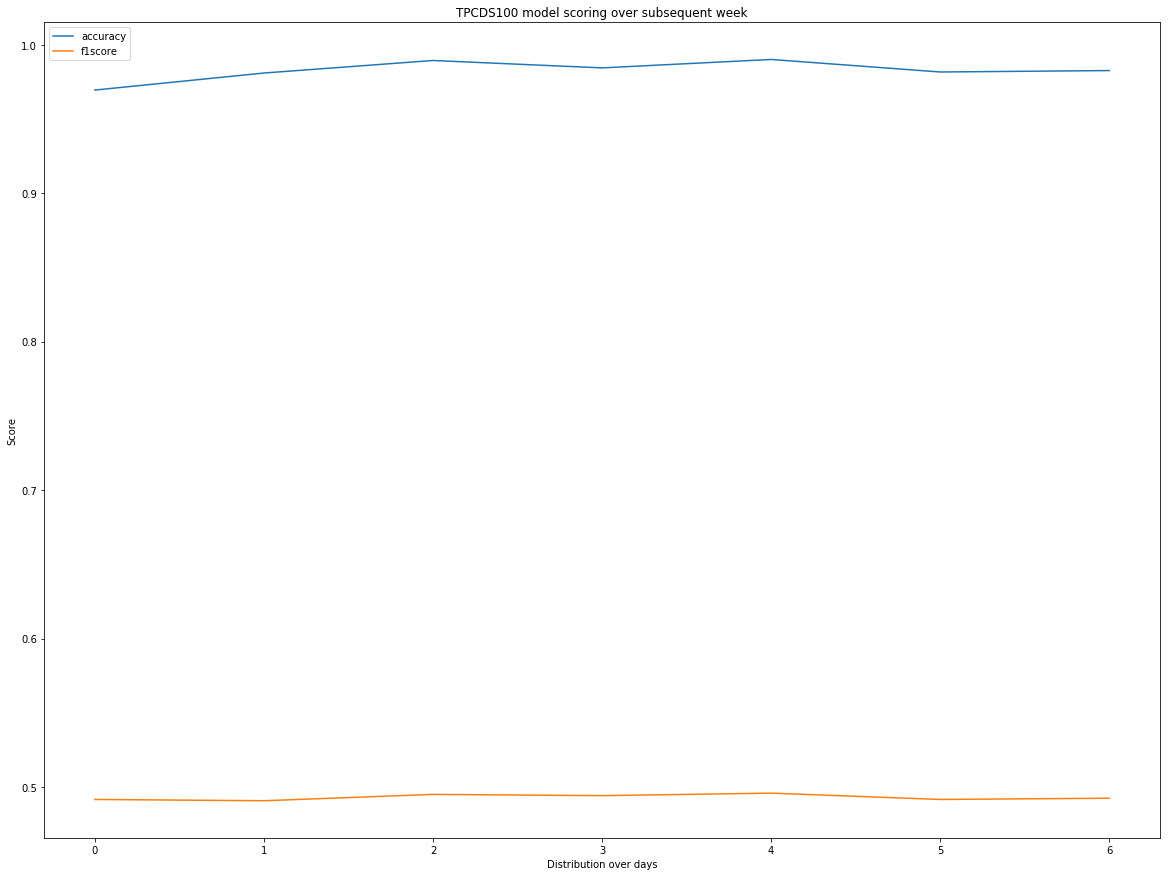

In [32]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (Equal to Lag) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(527, 12, 64)] Type - <class 'numpy.ndarray'>
y_train shape [(527, 24)] Type - <class 'numpy.ndarray'>
X_validate shape [(527, 12, 64)] Type - <class 'numpy.ndarray'>
y_validate shape [(527, 24)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 12, 64)            33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
Total

INFO:plaidml:Analyzing Ops: 2519 of 2778 operations complete


 - 16s - loss: 0.1606 - mean_squared_error: 0.1606 - mean_absolute_error: 0.3660 - val_loss: 0.1559 - val_mean_squared_error: 0.1559 - val_mean_absolute_error: 0.3664
Epoch 2/50
 - 0s - loss: 0.1379 - mean_squared_error: 0.1379 - mean_absolute_error: 0.3411 - val_loss: 0.1108 - val_mean_squared_error: 0.1108 - val_mean_absolute_error: 0.3120
Epoch 3/50
 - 0s - loss: 0.0874 - mean_squared_error: 0.0874 - mean_absolute_error: 0.2700 - val_loss: 0.0643 - val_mean_squared_error: 0.0643 - val_mean_absolute_error: 0.2280
Epoch 4/50
 - 0s - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1964 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1723
Epoch 5/50
 - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1598 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1558
Epoch 6/50
 - 0s - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1492 - val_loss: 0.0453 - val_mean_squa

Epoch 48/50
 - 0s - loss: 0.0405 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1273 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1353
Epoch 49/50
 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1263 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1352
Epoch 50/50
 - 0s - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1264 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1352


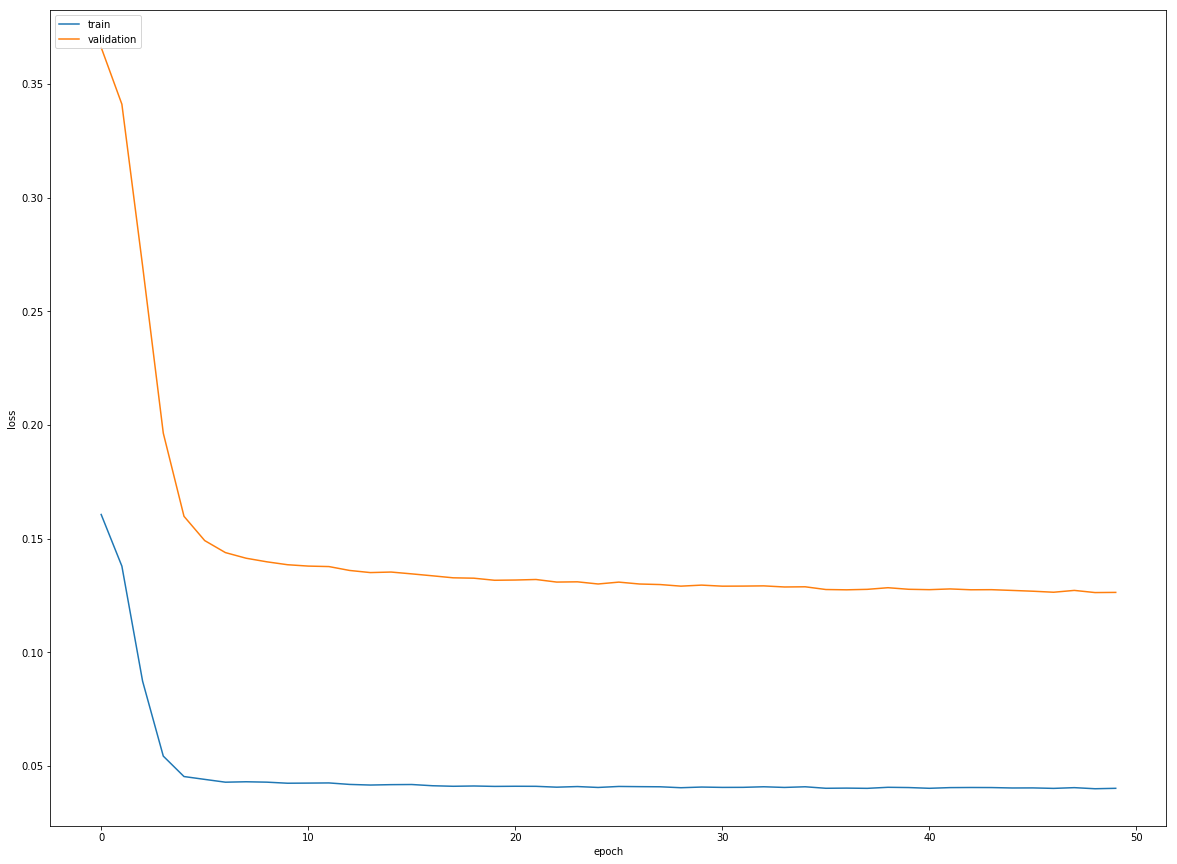

Wall time: 38.3 s


In [33]:
%%time
timestep = lag
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (Equal to Lag) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [34]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[i,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for i in range(yhat.shape[0]):
            if i % 2 == 0:
                #print('CPU')
                y[i] = BinClass.discretize_value(y[i], cpu_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], cpu_avg)
            else:
                #print('IO')
                y[i] = BinClass.discretize_value(y[i], io_avg)
                yhat[i] = BinClass.discretize_value(yhat[i], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for i in range(lag * len(y_label)):
        print('Label: ' + str(i))
        acc = accuracy_score(y_list[:,i],yhat_list[:,i])
        f1 = f1_score(y_list[:,i],yhat_list[:,i], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(i+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (75, 12, 64)
Label vectors: (75, 24)
Label: 0
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.9733333333333334
F1Score: 0.9864864864864865
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
La

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.92
F1Score: 0.9583333333333334
--------------------------
Label: 13
Accuracy: 1.0
F1Score: 0.0
--------------------------
La

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 13
Accuracy: 1.0
F1Score: 0.0
--------------------------
La

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

Label: 0
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 1
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 2
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 3
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 4
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 5
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 6
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 7
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 8
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 9
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 10
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 11
Accuracy: 1.0
F1Score: 0.0
--------------------------
Label: 12
Accuracy: 0.96
F1Score: 0.9795918367346939
--------------------------
Label: 13
Accuracy: 1.0
F1Score: 0.0
--------------------------
La

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

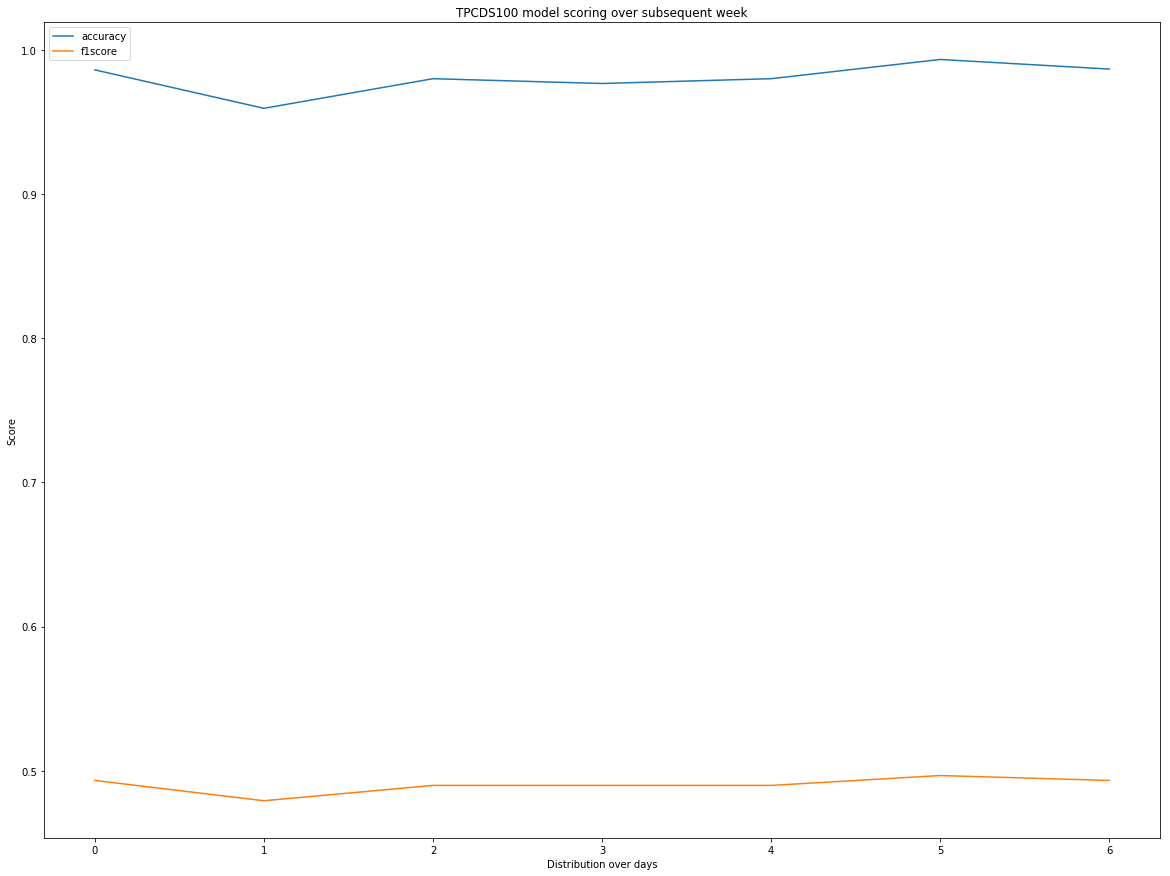

In [35]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()